In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch


In [2]:
data = pd.read_csv('ton_iot.csv')

In [3]:
data.type.value_counts()

scanning      7140161
ddos          6165008
dos           3375328
xss           2108944
password      1365958
normal         788599
backdoor       508116
injection      452659
ransomware      72805
mitm             1052
Name: type, dtype: int64

In [4]:
#df = data.drop(data[(data.type == 'mitm') & (data.type > 'ransomware')].index)

In [5]:
#mitm = data[data['type'] == 'mitm']
#ransomware = data[data['type'] == 'ransomware']

In [6]:
data = data.sample(frac=0.1,random_state = 123)

In [7]:
#data = pd.concat([df,mitm,ransomware], axis=0, ignore_index=True)

In [8]:
data

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
11296090,1556027596,192.168.1.32,64386.0,192.168.35.70,80.0,tcp,-,0.000000,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,scanning
4548155,1556226499,192.168.1.31,54888.0,192.168.1.190,80.0,tcp,-,0.000011,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,ddos
21842540,1556221235,192.168.1.31,55574.0,192.168.1.152,80.0,tcp,-,41.465948,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,ddos
17338199,1556367296,192.168.1.35,44801.0,192.168.1.1,53.0,udp,dns,0.030778,80.0,112.0,...,0.0,0.0,-,-,-,-,-,-,1.0,xss
10681504,1556310888,192.168.1.32,43152.0,192.168.1.190,80.0,tcp,http,0.002832,155.0,651.0,...,0.0,0.0,-,-,-,-,-,-,1.0,password
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471056,1556357235,192.168.1.39,51289.0,192.168.1.1,53.0,udp,dns,0.004012,74.0,90.0,...,0.0,0.0,-,-,-,-,-,-,1.0,xss
10714842,1556311785,192.168.1.32,50610.0,192.168.1.195,80.0,tcp,http,0.369658,263.0,467.0,...,0.0,0.0,-,-,-,-,-,-,1.0,password
16581481,1556234656,192.168.1.30,55230.0,192.168.1.190,80.0,tcp,-,0.000411,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,ddos
13464835,1556076381,192.168.1.190,5961.0,192.168.1.32,57548.0,tcp,-,0.000000,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,scanning


In [9]:
data['src_ip'] = data.src_ip.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [10]:
data['src_ip'] = data.src_ip.apply(str)
data['src_port'] = data.src_port.apply(str)
data['dst_ip'] = data.dst_ip.apply(str)
data['dst_port'] = data.dst_port.apply(str)

In [11]:
data['src_ip'] = data['src_ip'] + ':' + data['src_port']
data['dst_ip'] = data['dst_ip'] + ':' + data['dst_port']

In [12]:
data.type.value_counts()

scanning      713644
ddos          617121
dos           336744
xss           211404
password      136342
normal         78957
backdoor       50779
injection      45449
ransomware      7319
mitm             104
Name: type, dtype: int64

In [13]:
data['http_trans_depth'].unique()

array(['-', '1', '2', '7', '3', '5'], dtype=object)

In [14]:
data.drop(columns=['ts','src_port','dst_port','http_uri','weird_name','weird_addl','weird_notice','dns_query','ssl_subject','ssl_issuer','http_user_agent','type'],inplace=True)

In [15]:
#le = LabelEncoder()
#le.fit(data.label.values)
#data['label'] = le.transform(data['label'])

In [16]:
data['label'] = data.label.apply(int)

In [17]:
label = data.label

In [18]:
data.drop(columns=['label'],inplace = True)

In [19]:
scaler = StandardScaler()

In [20]:
data =  pd.concat([data, label], axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [22]:
X_train

,src_ip,dst_ip,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,ssl_established,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,http_orig_mime_types,http_resp_mime_types,label
12518989,172.22.130.149:5906.0,192.168.1.194:5906.0,tcp,-,0.000020,0.0,0.0,REJ,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
16767139,172.29.77.4:55306.0,192.168.1.1:53.0,udp,dns,0.002121,43.0,43.0,SF,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
15443196,172.18.90.201:3.0,192.168.1.194:3.0,tcp,-,0.000024,0.0,0.0,REJ,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
8315251,172.16.104.4:38932.0,18.194.169.124:80.0,tcp,http,1.179152,2806.0,1456.0,SF,0.0,7.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
5080887,172.30.105.50:40210.0,192.168.1.190:80.0,tcp,-,0.000385,0.0,0.0,S1,0.0,2.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16954071,172.21.86.98:42124.0,192.168.1.184:80.0,tcp,http,0.012523,196.0,107.0,SF,0.0,6.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
5608250,172.16.105.142:48974.0,192.168.1.194:80.0,tcp,-,6.098154,0.0,0.0,S1,0.0,2.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
16899259,172.22.79.223:58146.0,192.168.1.184:443.0,tcp,-,60.515091,0.0,0.0,S3,0.0,2.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
16292605,172.28.55.230:52940.0,192.168.1.184:443.0,tcp,-,64.609299,0.0,0.0,S3,0.0,3.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1


In [23]:
encoder = ce.TargetEncoder(cols=['proto','service','conn_state','dns_qclass','dns_qtype','dns_rcode','dns_AA','dns_RD','dns_RA','dns_rejected','ssl_version','ssl_cipher','ssl_resumed','ssl_established','http_method','http_version','http_status_code','http_orig_mime_types','http_resp_mime_types','http_trans_depth'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [24]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [25]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [26]:
X_train

,src_ip,dst_ip,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,http_orig_mime_types,http_resp_mime_types,label,h
12518989,172.22.130.149:5906.0,192.168.1.194:5906.0,0.27687,0.196550,-0.091245,-0.027508,-0.023848,0.500885,-0.007537,-0.028383,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, -0.012225578106630998, ..."
16767139,172.29.77.4:55306.0,192.168.1.1:53.0,-3.18382,-3.544340,-0.091223,-0.027507,-0.023847,-0.012306,-0.007537,-0.028383,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[-0.3270084691238662, -0.011169861427262529, -..."
15443196,172.18.90.201:3.0,192.168.1.194:3.0,0.27687,0.196550,-0.091245,-0.027508,-0.023848,0.500885,-0.007537,-0.028383,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, -0.012225578106630998, ..."
8315251,172.16.104.4:38932.0,18.194.169.124:80.0,0.27687,0.595997,-0.079040,-0.027426,-0.023804,-0.012306,-0.007537,0.026424,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, 0.09464019414686126, 0...."
5080887,172.30.105.50:40210.0,192.168.1.190:80.0,0.27687,0.196550,-0.091241,-0.027508,-0.023848,0.459808,-0.007537,-0.019249,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, -0.009773590980355842, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16954071,172.21.86.98:42124.0,192.168.1.184:80.0,0.27687,0.595997,-0.091115,-0.027502,-0.023845,-0.012306,-0.007537,0.017290,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, 0.003984781228188094, 0..."
5608250,172.16.105.142:48974.0,192.168.1.194:80.0,0.27687,0.196550,-0.028127,-0.027508,-0.023848,0.459808,-0.007537,-0.019249,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, -0.010046033994386415, ..."
16899259,172.22.79.223:58146.0,192.168.1.184:443.0,0.27687,0.196550,0.535105,-0.027508,-0.023848,0.498219,-0.007537,-0.019249,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, -0.009773590980355842, ..."
16292605,172.28.55.230:52940.0,192.168.1.184:443.0,0.27687,0.196550,0.577481,-0.027508,-0.023848,0.498219,-0.007537,-0.010114,...,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1,"[0.020306524458986664, -0.008002711389157117, ..."


In [27]:
G = nx.from_pandas_edgelist(X_train, "src_ip", "dst_ip", ['h','label'],create_using=nx.MultiGraph())

In [28]:
G = G.to_directed()

In [29]:
G = from_networkx(G,edge_attrs=['h','label'] )

In [30]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [31]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [32]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [33]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [34]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [35]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [36]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [37]:
G.ndata['h'].device


device(type='cuda', index=0)

In [38]:
G.edata['h'].device


device(type='cuda', index=0)

In [39]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(G.edata['label'].cpu().numpy()),
                                                 G.edata['label'].cpu().numpy())

In [40]:
#class_weights = [10,1]

In [41]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [42]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [43]:
import os

In [44]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())


for epoch in range(1,3500):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 100  Training acc: 0.9724498391151428
Epoch: 200  Training acc: 0.9738720059394836
Epoch: 300  Training acc: 0.9744514226913452
Epoch: 400  Training acc: 0.9753386974334717
Epoch: 500  Training acc: 0.9754420518875122
Epoch: 600  Training acc: 0.9762665033340454
Epoch: 700  Training acc: 0.9762275218963623
Epoch: 800  Training acc: 0.9761020541191101
Epoch: 900  Training acc: 0.9765200018882751
Epoch: 1000  Training acc: 0.976667582988739
Epoch: 1100  Training acc: 0.9766178131103516
Epoch: 1200  Training acc: 0.97658371925354
Epoch: 1300  Training acc: 0.9766139388084412
Epoch: 1400  Training acc: 0.9765151739120483
Epoch: 1500  Training acc: 0.9767189025878906
Epoch: 1600  Training acc: 0.9763389825820923
Epoch: 1700  Training acc: 0.976122260093689
Epoch: 1800  Training acc: 0.9771137833595276
Epoch: 1900  Training acc: 0.9771524667739868
Epoch: 2000  Training acc: 0.9764358401298523
Epoch: 2100  Training acc: 0.9778047204017639
Epoch: 2200  Training acc: 0.9780842065811157
E

In [45]:
X_test = encoder.transform(X_test)

In [46]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [47]:
X_test

,src_ip,dst_ip,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,ssl_established,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,http_orig_mime_types,http_resp_mime_types,label
16917728,172.25.194.104:52364.0,192.168.1.190:80.0,0.27687,0.196550,-0.091242,-0.027508,-0.023848,0.459808,-0.007537,-0.019249,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
5551382,172.25.235.51:44936.0,192.168.1.1:53.0,-3.18382,-3.544340,-0.091201,-0.027507,-0.023847,-0.012306,-0.007537,-0.028383,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
568557,172.29.79.142:376.0,192.168.1.193:376.0,0.27687,0.196550,-0.091245,-0.027508,-0.023848,0.500885,-0.007537,-0.028383,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
17657520,172.30.242.165:49159.0,192.168.1.37:8001.0,0.27687,0.196550,-0.091245,-0.027508,-0.023848,-4.705624,-0.007537,-0.028383,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
7559197,172.24.62.198:60578.0,192.168.1.190:80.0,0.27687,0.595997,-0.091226,-0.027503,-0.023762,-0.012306,-0.007537,0.008155,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17237283,172.18.136.0:59267.0,192.168.1.1:53.0,-3.18382,-3.544340,-0.045602,-0.027504,-0.023843,-0.012306,-0.007537,-0.000980,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
15809665,172.17.19.25:38712.0,192.168.1.190:80.0,0.27687,0.595997,-0.091219,-0.027503,-0.023758,-0.012306,-0.007537,0.008155,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
3430755,172.23.134.183:20102.0,192.168.1.152:14716.0,0.27687,0.196550,-0.091181,-0.027508,-0.023848,0.500885,-0.007537,-0.028383,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1
12263615,172.25.130.150:5433.0,192.168.1.190:5433.0,0.27687,0.196550,-0.091244,-0.027508,-0.023848,0.500885,-0.007537,-0.028383,...,-0.002536,-0.032746,-0.030454,-0.032517,-0.001991,-0.003418,-0.016846,-0.007433,-0.001272,1


In [48]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [49]:
G_test = nx.from_pandas_edgelist(X_test, "src_ip", "dst_ip", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),G.ndata['h'].shape[2])

In [50]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [51]:
G_test = G_test.to('cuda:0')

In [52]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [53]:
print(str(elapsed) + ' seconds')

0.09288323899818351 seconds


In [54]:
test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [59]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [60]:
from sklearn.metrics import plot_confusion_matrix


In [61]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

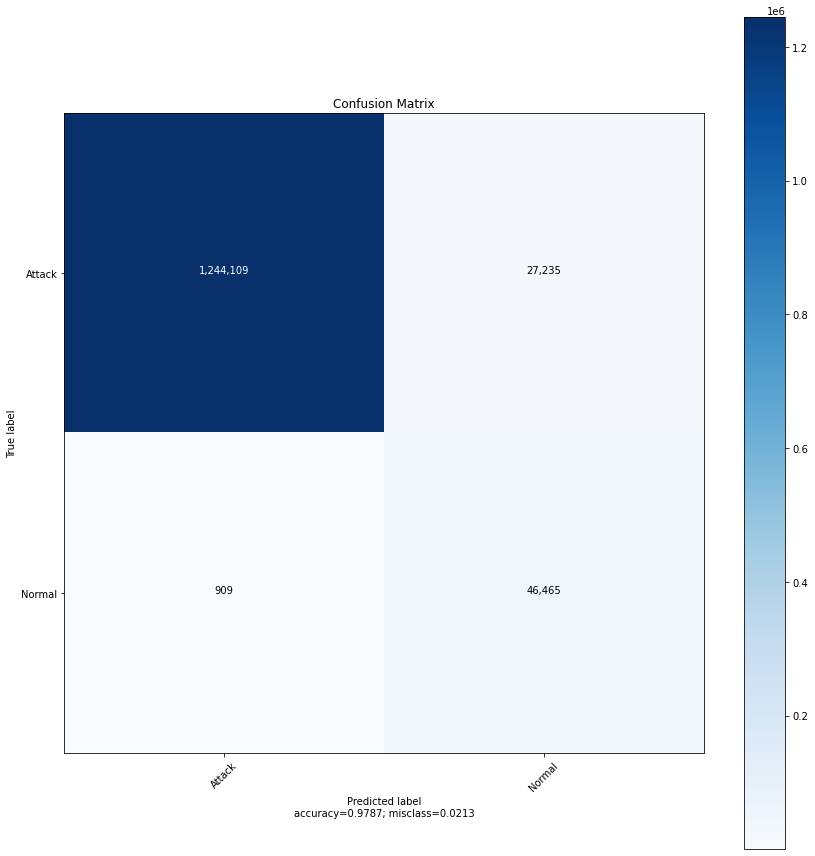

In [62]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [63]:
from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9993    0.9786    0.9888   1271344
      Normal     0.6305    0.9808    0.7675     47374

    accuracy                         0.9787   1318718
   macro avg     0.8149    0.9797    0.8782   1318718
weighted avg     0.9860    0.9787    0.9809   1318718



In [64]:
th.save(model.state_dict(), 'ton-iot.binary.pt')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=2))

In [ ]:
report = classification_report(actual, test_pred, digits=4, output_dict=True)

In [ ]:
df = pd.DataFrame(report).transpose()

In [ ]:
df.to_csv('unsw_ton_iot_agg_report.csv')

In [ ]:
df

In [ ]:
th.save(model.state_dict(), 'unsw_ton_iot_agg_mul.pt')
